In [83]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [3]:
data = pd.read_csv('transaction_data_with_seasonality_100k.csv', parse_dates=['transaction_date'])

In [4]:
item_id = 1

In [5]:
data.set_index('transaction_date', inplace=True)

In [6]:
weekly_data = data.groupby(['item_id']).resample('W').agg({
    'quantity': 'sum',
    'price': 'mean'
}).reset_index()

In [7]:
item_data = weekly_data[(weekly_data['item_id'] == item_id)] 
item_data.set_index('transaction_date', inplace=True) 


<Axes: xlabel='transaction_date'>

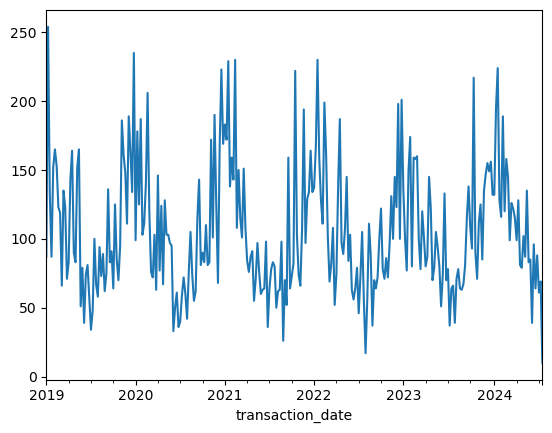

In [8]:
item_data['quantity'].plot()

In [9]:
# Split the data into train and test sets
train_size = int(len(item_data) * 0.8) 
train_data, test_data = item_data[:train_size], item_data[train_size:] 


In [10]:
model = SARIMAX(train_data['quantity'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))  # Annual seasonality
model_fit = model.fit(disp=False) 


/Users/khair1212/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/khair1212/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/khair1212/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [11]:
# Forecast  
forecast = model_fit.forecast(steps=len(test_data))  

# Evaluate the model 
mse = mean_squared_error(test_data['quantity'], forecast) 
r2 = r2_score(test_data['quantity'], forecast) 
rmse = np.sqrt(mse) 
print(f'RMSE (Weekly): {rmse} \n R2 (Weekly): {r2}') 

RMSE (Weekly): 32.70170001373095 
 R2 (Weekly): 0.42355735218362833


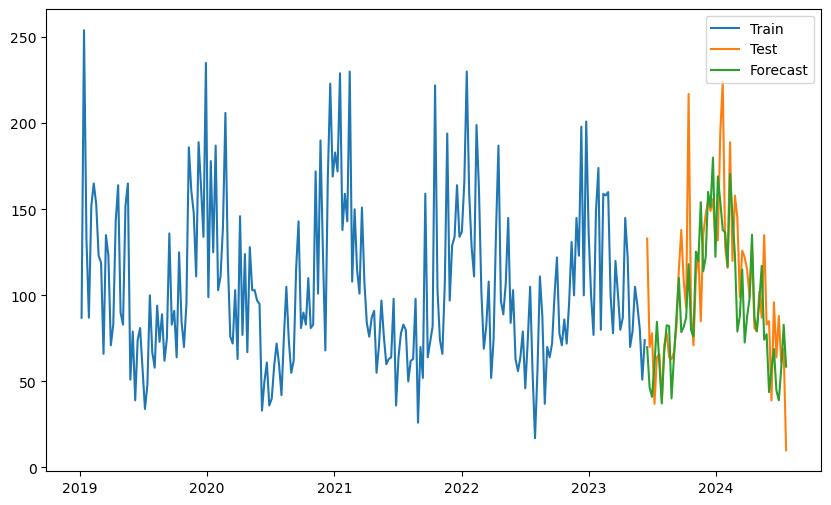

In [13]:

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['quantity'], label='Train')
plt.plot(test_data.index, test_data['quantity'], label='Test')
# plt.plot(train_data.index, train_forecast, label='Train Forecast')
plt.plot(test_data.index, forecast, label='Forecast')
plt.legend()
plt.show()

# Feature Engineering 

In [14]:
p_weekly_data = weekly_data.copy()

In [15]:
p_weekly_data['day_of_week'] = p_weekly_data['transaction_date'].dt.dayofweek
p_weekly_data['month'] = p_weekly_data['transaction_date'].dt.month
p_weekly_data['year'] = p_weekly_data['transaction_date'].dt.year



In [16]:
p_weekly_data

,item_id,transaction_date,quantity,price,day_of_week,month,year
0,1,2019-01-06,87,26.974393,6,1,2019
1,1,2019-01-13,254,26.450201,6,1,2019
2,1,2019-01-20,133,31.539788,6,1,2019
3,1,2019-01-27,87,21.265302,6,1,2019
4,1,2019-02-03,152,29.766907,6,2,2019
...,...,...,...,...,...,...,...
5795,20,2024-06-23,82,40.445372,6,6,2024
5796,20,2024-06-30,70,39.677920,6,6,2024
5797,20,2024-07-07,36,38.607004,6,7,2024
5798,20,2024-07-14,57,35.237258,6,7,2024


In [17]:
# Add lag features
p_weekly_data['lag_1'] = p_weekly_data['quantity'].shift(1)
p_weekly_data['lag_3'] = p_weekly_data['quantity'].shift(3)
p_weekly_data['lag_5'] = p_weekly_data['quantity'].shift(5)


In [18]:
# Add rolling statistics
p_weekly_data['rolling_mean_3'] = p_weekly_data['quantity'].rolling(window=3).mean()
p_weekly_data['rolling_std_3'] = p_weekly_data['quantity'].rolling(window=3).std()
p_weekly_data['rolling_mean_7'] = p_weekly_data['quantity'].rolling(window=7).mean()
p_weekly_data['rolling_std_7'] = p_weekly_data['quantity'].rolling(window=7).std()


In [19]:
# Ensure no missing values in new features
p_weekly_data.dropna(inplace=True)

In [20]:

p_item_data = p_weekly_data[(p_weekly_data['item_id'] == item_id)]
p_item_data.set_index('transaction_date', inplace=True)


In [21]:
# Split the data into train and test sets
train_size = int(len(p_item_data) * 0.8)
train_data, test_data = p_item_data[:train_size], p_item_data[train_size:]


In [22]:
# Define the exogenous features
exog_features = ['price', 'day_of_week', 'month', 'year', 'lag_1', 'rolling_mean_3', 'rolling_std_3']


In [23]:
# Train the model 
model = SARIMAX(train_data['quantity'], 
                order=(1, 1, 1), 
                seasonal_order=(1, 1, 1, 52),  # Weekly seasonality 
                exog=train_data[exog_features]) 
model_fit = model.fit(disp=False) 

/Users/khair1212/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/khair1212/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/khair1212/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/khair1212/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [24]:
# Forecast 
# train_forecast = model_fit.forecast(steps=len(train_data), exog=train_data[exog_features]) 
test_forecast = model_fit.forecast(steps=len(test_data), exog=test_data[exog_features]) 

In [25]:
# Evaluate the model
mse = mean_squared_error(test_data['quantity'], test_forecast) 
r2 = r2_score(test_data['quantity'], test_forecast) 
rmse = np.sqrt(mse) 
print(f'SARIMAX RMSE: {rmse} \n R2: {r2}') 

SARIMAX RMSE: 28.463975457353243 
 R2: 0.5676951155857419


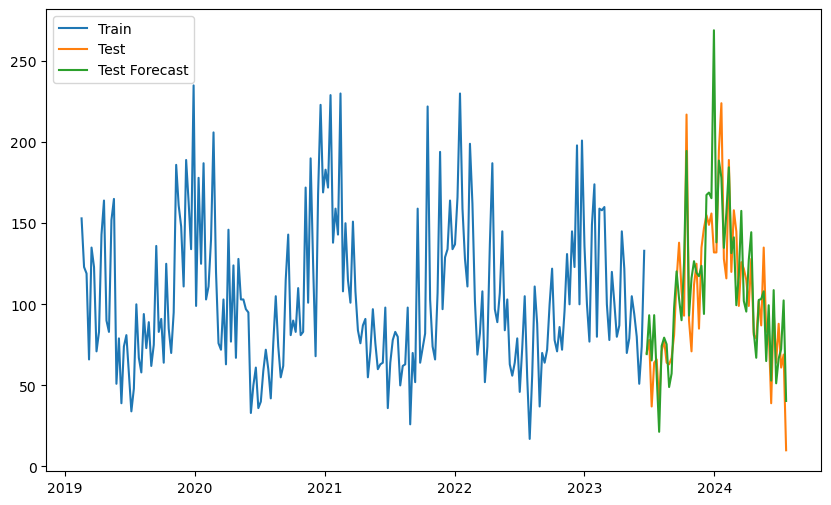

In [26]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['quantity'], label='Train')
plt.plot(test_data.index, test_data['quantity'], label='Test')
# plt.plot(train_data.index, train_forecast, label='Train Forecast')
plt.plot(test_data.index, test_forecast, label='Test Forecast')
plt.legend()
plt.show()

# Prophet

In [27]:
item_data.head()


,item_id,quantity,price
transaction_date,,,
2019-01-06,1,87,26.974393
2019-01-13,1,254,26.450201
2019-01-20,1,133,31.539788
2019-01-27,1,87,21.265302
2019-02-03,1,152,29.766907


In [28]:
item_data_prophet = item_data.reset_index()[['transaction_date', 'quantity']].rename(columns={'transaction_date': 'ds', 'quantity': 'y'})


In [29]:
train_size = int(len(item_data_prophet) * 0.8)
train_data, test_data = item_data_prophet[:train_size], item_data_prophet[train_size:]


In [30]:
model = Prophet(yearly_seasonality=True)
model.fit(train_data)

03:29:14 - cmdstanpy - INFO - Chain [1] start processing
03:29:14 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
# Make future dataframe and forecast
future = model.make_future_dataframe(periods=len(test_data), freq='W')
forecast = model.predict(future)

In [32]:


# Evaluate the model
mse = mean_squared_error(test_data['y'], forecast['yhat'][len(train_data):])
r2 = r2_score(test_data['y'], forecast['yhat'][len(train_data):])
rmse = np.sqrt(mse)
print(f'Prophet RMSE: {rmse} \n R2: {r2}')

Prophet RMSE: 31.909670975817825 
 R2: 0.4511418768471861


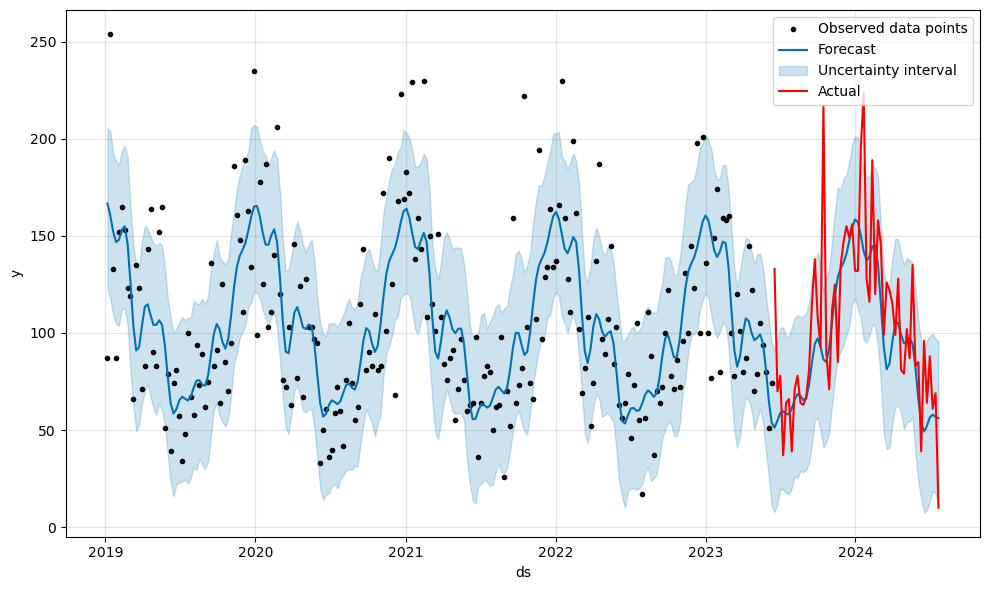

In [33]:
# Plot the forecast
# Plot the forecast
fig = model.plot(forecast)
# plt.plot(train_data['ds'], train_data['y'], color = 'red')
plt.plot(test_data['ds'], test_data['y'], 'r', label='Actual')
plt.legend()
plt.show()

#  Feature Engineering

In [34]:
p_item_data_prophet = p_item_data[['quantity']].reset_index().rename(columns={'transaction_date': 'ds', 'quantity': 'y'})


In [35]:
p_item_data.head()

,item_id,quantity,price,day_of_week,month,year,lag_1,lag_3,lag_5,rolling_mean_3,rolling_std_3,rolling_mean_7,rolling_std_7
transaction_date,,,,,,,,,,,,,
2019-02-17,1,153,25.286403,6,2,2019,165.0,87.0,254.0,156.666667,7.234178,147.285714,56.611878
2019-02-24,1,123,32.240177,6,2,2019,153.0,152.0,133.0,147.000000,21.633308,152.428571,51.639317
2019-03-03,1,119,26.042253,6,3,2019,123.0,165.0,87.0,131.666667,18.583146,133.142857,26.447612
2019-03-10,1,66,32.922488,6,3,2019,119.0,153.0,152.0,102.666667,31.817186,123.571429,36.659956
2019-03-17,1,135,32.826997,6,3,2019,66.0,123.0,165.0,106.666667,36.115555,130.428571,32.984123


In [36]:
# Adding additional regressors
p_item_data_prophet['price'] = p_item_data['price'].values
p_item_data_prophet['day_of_week'] = p_item_data['day_of_week'].values
p_item_data_prophet['month'] = p_item_data['month'].values
p_item_data_prophet['year'] = p_item_data['year'].values
p_item_data_prophet['lag_1'] = p_item_data['lag_1'].values
p_item_data_prophet['lag_3'] = p_item_data['lag_3'].values

p_item_data_prophet['rolling_mean_7'] = p_item_data['rolling_mean_7'].values
p_item_data_prophet['rolling_std_7'] = p_item_data['rolling_std_7'].values


p_item_data_prophet['rolling_mean_3'] = p_item_data['rolling_mean_3'].values
p_item_data_prophet['rolling_std_3'] = p_item_data['rolling_std_3'].values

In [37]:
train_size = int(len(p_item_data_prophet) * 0.8)
train_data, test_data = p_item_data_prophet[:train_size], p_item_data_prophet[train_size:]


In [38]:
# Define and fit the model
model = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
model.add_regressor('price')
model.add_regressor('day_of_week')
model.add_regressor('month')
model.add_regressor('year')
model.add_regressor('lag_1')
model.add_regressor('lag_3')
model.add_regressor('rolling_mean_7')
model.add_regressor('rolling_std_7')
model.add_regressor('rolling_mean_3')
model.add_regressor('rolling_std_3')
model.fit(train_data)

03:29:48 - cmdstanpy - INFO - Chain [1] start processing
03:29:48 - cmdstanpy - INFO - Chain [1] done processing


In [39]:
# Make future dataframe and forecast
future = model.make_future_dataframe(periods=len(test_data), freq='W')

print(future.shape, test_data.shape)

(284, 1) (57, 12)


In [40]:
future = future.loc[len(train_data):]

In [41]:
future['price'] = test_data['price'].values
future['day_of_week'] = test_data['day_of_week'].values
future['month'] = test_data['month'].values
future['year'] = test_data['year'].values
future['lag_1'] = test_data['lag_1'].values
future['lag_3'] = test_data['lag_3'].values
future['rolling_mean_7'] = test_data['rolling_mean_7'].values
future['rolling_std_7'] = test_data['rolling_std_7'].values
future['rolling_mean_3'] = test_data['rolling_mean_3'].values
future['rolling_std_3'] = test_data['rolling_std_3'].values

forecast = model.predict(future)

In [42]:
# Evaluate the model
mse = mean_squared_error(test_data['y'], forecast['yhat'])
r2 = r2_score(test_data['y'], forecast['yhat'])
rmse = np.sqrt(mse)
print(f'Prophet RMSE: {rmse} \n R2: {r2}')

Prophet RMSE: 22.504933158869004 
 R2: 0.7297569805352264


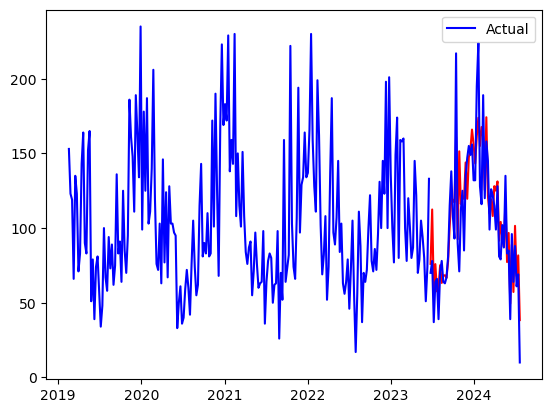

In [51]:
# Plot the forecast
# fig = model.plot(forecast)
plt.plot(test_data['ds'], forecast['yhat'], 'red')
plt.plot(train_data['ds'], train_data['y'], color = 'blue')
plt.plot(test_data['ds'], test_data['y'], 'blue', label='Actual')
# plt.plot(forecast)
plt.legend()
plt.show()

In [62]:
plt_data  = pd.DataFrame({'ds': test_data['ds'], 'actual': test_data['y']})

In [74]:
plt_data = pd.merge(plt_data, forecast, on='ds')[['ds', 'actual', 'yhat']]

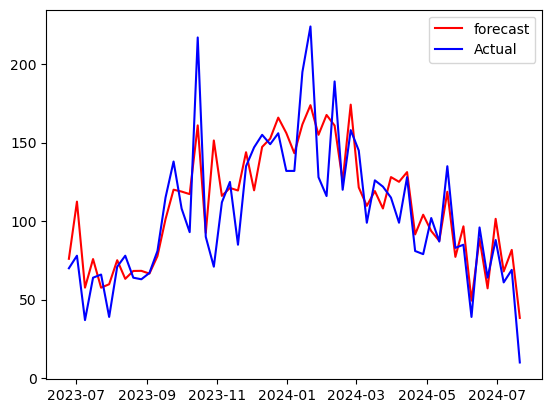

In [77]:
# Plot the forecast
# plt.plot(train_data['date'], train_data['quantity'], color = 'blue')
plt.plot(plt_data['ds'], plt_data['yhat'], color = 'red', label = 'forecast')
plt.plot(plt_data['ds'], plt_data['actual'], 'blue', label='Actual')
plt.legend()
plt.show()

# XGBoost 

In [84]:
rf_data = p_item_data.reset_index()

In [85]:
rf_data.head()

,transaction_date,item_id,quantity,price,day_of_week,month,year,lag_1,lag_3,lag_5,rolling_mean_3,rolling_std_3,rolling_mean_7,rolling_std_7
0,2019-02-17,1,153,25.286403,6,2,2019,165.0,87.0,254.0,156.666667,7.234178,147.285714,56.611878
1,2019-02-24,1,123,32.240177,6,2,2019,153.0,152.0,133.0,147.000000,21.633308,152.428571,51.639317
2,2019-03-03,1,119,26.042253,6,3,2019,123.0,165.0,87.0,131.666667,18.583146,133.142857,26.447612
3,2019-03-10,1,66,32.922488,6,3,2019,119.0,153.0,152.0,102.666667,31.817186,123.571429,36.659956
4,2019-03-17,1,135,32.826997,6,3,2019,66.0,123.0,165.0,106.666667,36.115555,130.428571,32.984123


In [86]:
train_size = int(len(rf_data) * 0.8)
train_data, test_data = rf_data[:train_size], rf_data[train_size:]


In [87]:
X_train = train_data.drop(['quantity', 'item_id', 'transaction_date', 'day_of_week'], axis = 1)
y_train = train_data['quantity']

X_test = test_data.drop(['quantity', 'item_id', 'transaction_date', 'day_of_week'], axis=1)
y_test = test_data['quantity']



In [88]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [89]:
forecast = xgb.predict(X_test)

In [90]:
# Evaluate the model
mse = mean_squared_error(y_test, forecast)
r2 = r2_score(y_test, forecast)
rmse = np.sqrt(mse)
print(f'XGBoost RMSE: {rmse} \n R2: {r2}')

Prophet RMSE: 30.132342308133815 
 R2: 0.515532374382019


In [91]:
plt_data  = pd.DataFrame({'date': test_data['transaction_date'], 'forecast': forecast, 'actual': y_test})

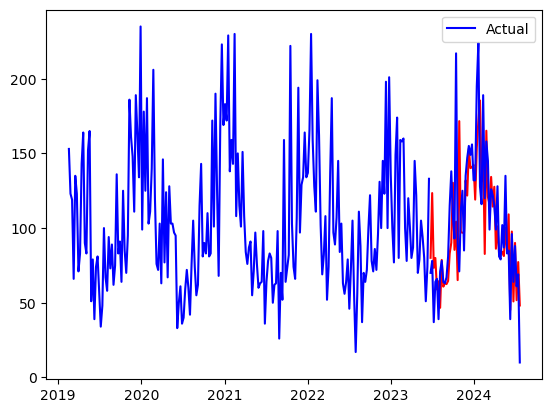

In [92]:
# Plot the forecast
plt.plot(train_data['transaction_date'], train_data['quantity'], color = 'blue')
plt.plot(plt_data['date'], plt_data['forecast'], color = 'red')
plt.plot(plt_data['date'], plt_data['actual'], 'blue', label='Actual')
plt.legend()
plt.show()

In [93]:
plt_data

,date,forecast,actual
227,2023-06-25,80.099174,70
228,2023-07-02,123.440010,78
229,2023-07-09,73.365448,37
230,2023-07-16,79.961754,64
231,2023-07-23,58.892300,66
232,2023-07-30,64.362099,39
233,2023-08-06,46.623478,71
234,2023-08-13,78.654793,78
235,2023-08-20,60.761154,64
236,2023-08-27,63.153263,63


# Random Forest 

In [94]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [95]:
forecast = rf.predict(X_test)

In [96]:
# Evaluate the model
mse = mean_squared_error(y_test, forecast)
r2 = r2_score(y_test, forecast)
rmse = np.sqrt(mse)
print(f'Random Forest RMSE: {rmse} \n R2: {r2}')

Random Forest RMSE: 25.778669034552237 
 R2: 0.6454152843638088


In [97]:
plt_data  = pd.DataFrame({'date': test_data['transaction_date'], 'forecast': forecast, 'actual': y_test})

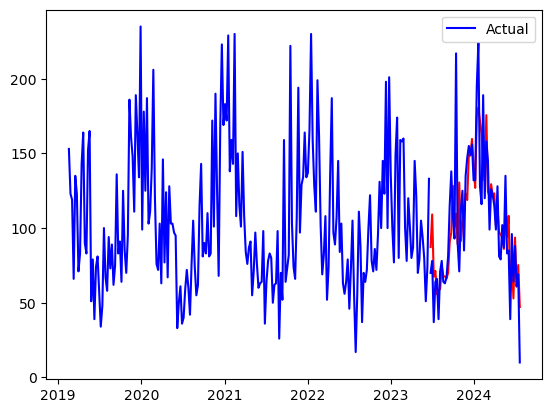

In [98]:
# Plot the forecast
plt.plot(train_data['transaction_date'], train_data['quantity'], color = 'blue')
plt.plot(plt_data['date'], plt_data['forecast'], color = 'red')
plt.plot(plt_data['date'], plt_data['actual'], 'blue', label='Actual')
plt.legend()
plt.show()

# CatBoost

In [99]:
from catboost import CatBoostRegressor

In [100]:
cb = CatBoostRegressor()
cb.fit(X_train, y_train)

Learning rate set to 0.032392
0:	learn: 44.3755381	total: 61.5ms	remaining: 1m 1s
1:	learn: 43.7858294	total: 62.1ms	remaining: 31s
2:	learn: 43.2504223	total: 62.8ms	remaining: 20.9s
3:	learn: 42.6912485	total: 63.3ms	remaining: 15.8s
4:	learn: 42.1155372	total: 63.8ms	remaining: 12.7s
5:	learn: 41.6492961	total: 64.3ms	remaining: 10.6s
6:	learn: 41.1765668	total: 64.8ms	remaining: 9.19s
7:	learn: 40.7657519	total: 65.2ms	remaining: 8.09s
8:	learn: 40.2746286	total: 65.7ms	remaining: 7.24s
9:	learn: 39.7883552	total: 66.2ms	remaining: 6.55s
10:	learn: 39.3392338	total: 66.7ms	remaining: 5.99s
11:	learn: 38.8380957	total: 67.2ms	remaining: 5.53s
12:	learn: 38.3744663	total: 67.7ms	remaining: 5.14s
13:	learn: 37.9549201	total: 68.1ms	remaining: 4.8s
14:	learn: 37.5625814	total: 68.6ms	remaining: 4.5s
15:	learn: 37.1391879	total: 69.1ms	remaining: 4.25s
16:	learn: 36.8282201	total: 69.6ms	remaining: 4.02s
17:	learn: 36.4183464	total: 70.2ms	remaining: 3.83s
18:	learn: 36.0835748	total: 7

In [101]:
forecast = cb.predict(X_test)

In [102]:
# Evaluate the model
mse = mean_squared_error(y_test, forecast)
r2 = r2_score(y_test, forecast)
rmse = np.sqrt(mse)
print(f'CatBoost RMSE: {rmse} \n R2: {r2}')

Random Forest RMSE: 26.57224689280064 
 R2: 0.6232479814270502


In [103]:
plt_data  = pd.DataFrame({'date': test_data['transaction_date'], 'forecast': forecast, 'actual': y_test})

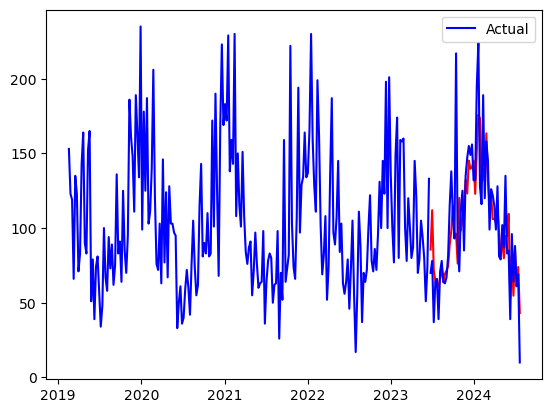

In [104]:
# Plot the forecast
plt.plot(train_data['transaction_date'], train_data['quantity'], color = 'blue')
plt.plot(plt_data['date'], plt_data['forecast'], color = 'red')
plt.plot(plt_data['date'], plt_data['actual'], 'blue', label='Actual')
plt.legend()
plt.show()